In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import requests
from striprtf.striprtf import rtf_to_text

load_dotenv()
# Set your OpenAI API key here
api_key = os.getenv("OPENAI_API_KEY")

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
import base64
import requests
from typing import List, TypedDict, Annotated, Optional
from striprtf.striprtf import rtf_to_text
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [6]:
class AgentState(TypedDict):
    url: Optional[str]
    messages: Annotated[list[AnyMessage], add_messages]
    raw_text: str
    summary:str

In [7]:
def extract_rtf_text(url: str) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text



def summarize_text(text: str) -> str:
    """
    Generate a short Ukrainian summary for the given text using an LLM model.
    """


    summarization_prompt = PromptTemplate.from_template(
        """Summarize the following text in one short sentence. Summarize to ukrainian.
        
        Text: {text}
        
        Summary:"""
    )

    chain = summarization_prompt | model

    response = chain.invoke({"text": text}).content

    return response


tools = [extract_rtf_text, summarize_text]


llm_with_tools = model.bind_tools(tools, parallel_tool_calls=False)

In [13]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_rtf_text(url: str) -> str:
    Download an RTF document from the given URL and extract plain text from it.

    Args:
        url (str): The URL of the RTF document.

    Returns:
        str: The extracted plain text from the given URL

summarize_text(text: str) -> str:
    Summarizes the given text using the LLM.
    
    Args:
        text (str): The text to summarize.
        
    Returns:
        str: The summary of the text.
"""
    prompt = f"""
    You are a helpful assistant. You can analyse summarize texts (court cases) and run computations with provided tools:\n{textual_description_of_tool} \n 
"""
    sys_msg = SystemMessage(content=prompt)

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
    }

In [14]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(AgentState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

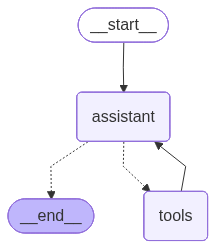

In [15]:
from IPython.display import Image, display

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
messages = [HumanMessage(content="Please Extract text from URL in RTF format. http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf")]
messages = react_graph.invoke({"messages": messages})

In [18]:
url = "http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf"
messages = [HumanMessage(content=f"Please Extract text from URL in RTF format {url}")]
messages = react_graph.invoke({"messages": messages})

In [30]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Please Extract text from URL in RTF format http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf
================================== Ai Message ==================================
Tool Calls:
  extract_rtf_text (call_VhYH97rVQv4C7giHe4Q6X1vE)
 Call ID: call_VhYH97rVQv4C7giHe4Q6X1vE
  Args:
    url: http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf
================================= Tool Message =================================
Name: extract_rtf_text


   КИЇВСЬКИЙ ОКРУЖНИЙ АДМІНІСТРАТИВНИЙ СУД |
У Х В А Л А
про залишення позовної заяви без руху
04 грудня 2024 року                           м. Київ                                     № 320/57291/24
Суддя Київського окружного адміністративного суду Жук Р.В., дослідивши матеріали адміністративного позову та додані до нього документи
за позовом   Товариства з обмеженою відповідальністю "Мегого"
до               

In [31]:
url = "http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf"
tt = extract_rtf_text(url)

In [36]:
messages = [HumanMessage(content=f"Ось лінка {url} твоя задача видобувати весь текст і сумаризувати його")]
messages = react_graph.invoke({"messages": messages})

In [37]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Ось лінка http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf твоя задача видобувати весь текст і сумаризувати його
================================== Ai Message ==================================
Tool Calls:
  extract_rtf_text (call_9iGGrAO5uXgZWNSdYDSZunzJ)
 Call ID: call_9iGGrAO5uXgZWNSdYDSZunzJ
  Args:
    url: http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf
================================= Tool Message =================================
Name: extract_rtf_text


   КИЇВСЬКИЙ ОКРУЖНИЙ АДМІНІСТРАТИВНИЙ СУД |
У Х В А Л А
про залишення позовної заяви без руху
04 грудня 2024 року                           м. Київ                                     № 320/57291/24
Суддя Київського окружного адміністративного суду Жук Р.В., дослідивши матеріали адміністративного позову та додані до нього документи
за позовом   Товариства з обмеженою відповідальністю "Мего

In [ ]:
# "You are a helpful assistant
# You can analyse summarize texts (court cases) and run computations with provided tools:\n{textual_description_of_tool} \n 
# You have access to some url. Currently the loaded url is: {url}")
